# MACHINE LEARNING

In this, we have to do topic modeling. For this purpose we used LDA model. Spark doesn't provide other models yet like NMF, LSA. Even though for topic modeling LDA is best approach(according literature review).

In [331]:
import findspark
findspark.init()

#System.setProperty("hadoop.home.dir", "E:\software\spark-3.0.0-preview2-bin-hadoop2.7\spark-3.0.0-preview2-bin-hadoop2.7\winutils.exe");


In [2]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

EXE_MEMORY = "2g"
DRIVER_MEMORY = "8g"
spark = SparkSession.builder.appName("AWSNLP").config("spark.executor.memory", EXE_MEMORY).config("spark.executor.cores", "2").config("spark.driver.memory", DRIVER_MEMORY).config("spark.cores.max", "10").getOrCreate()

In [3]:
df = spark.read.json('C:\\Users\\salon\\Downloads\\Magazine_Subscriptions.json')

In [4]:
df=df.select('reviewText', "overall")

In [5]:
from pyspark.sql.window import Window as W
from pyspark.sql import functions as F
df = df.withColumn("idx", F.monotonically_increasing_id())
windowSpec = W.orderBy("idx")
df.withColumn("idx", F.row_number().over(windowSpec)).show(2)

+--------------------+-------+---+
|          reviewText|overall|idx|
+--------------------+-------+---+
|for computer enth...|    5.0|  1|
|Thank god this is...|    5.0|  2|
+--------------------+-------+---+
only showing top 2 rows



In [7]:
from pyspark.sql.functions import regexp_replace, trim, col, lower
def removePunctuation(column):
    """Removes punctuation, changes to lower case, and strips leading and trailing spaces.

    Note:
        Only spaces, letters, and numbers should be retained.  Other characters should should be
        eliminated (e.g. it's becomes its).  Leading and trailing spaces should be removed after
        punctuation is removed.

    Args:
        column (Column): A Column containing a sentence.

    Returns:
        Column: A Column named 'sentence' with clean-up operations applied.
    """
    return trim(lower(regexp_replace(column, '[^\sa-zA-Z0-9]', ''))).alias('reviewText')

df=df.select("IDX", "overall", (removePunctuation(col('reviewText'))))
         


In [8]:
df=df.where(df.reviewText.isNotNull())

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql.types import *
from nltk import WordNetLemmatizer


# Tokenize text
tokenizer = Tokenizer(inputCol='reviewText', outputCol='words_token')
df_words_token = tokenizer.transform(df).select('IDX',"overall", 'words_token')

# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('IDX',"overall", 'words_clean')

#lemmatization
lemm=WordNetLemmatizer()
lemm_udf=udf(lambda tokens:[lemm.lemmatize(token) for token in tokens], ArrayType(StringType()))
df_lemm = df_words_no_stopw.withColumn("lemmi", lemm_udf("words_clean")).select('IDX',"overall", 'lemmi')

# Stem text
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
df_stemmed = df_lemm.withColumn("words_stemmed", stemmer_udf("lemmi")).select('IDX',"overall",'words_stemmed')


# Filter length word > 3
filter_length_udf = udf(lambda row: [x for x in row if len(x) > 3], ArrayType(StringType()))
df_final_words = df_stemmed.withColumn('words', filter_length_udf(col('words_stemmed'))).select('IDX',"overall", 'words')

## COUNTVECTORIZER

In this after cleaning data and removing null values, we applied countvectorizer. This converts text documents to vectors of term counts. WE can see below with column name "features".

In [11]:
from pyspark.ml.feature import CountVectorizer
from pyspark.mllib.linalg import Vectors

cv=CountVectorizer(inputCol="words", outputCol="features")

model=cv.fit(df_final_words)

result=model.transform(df_final_words)

In [14]:
result.show(5, False)

+---+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# SPLITTING DATASET

Here we splitted dataset to training and test dataset. 70% data in training and rest in test. We used seed 100 to get everytime same randamized distribution of datasets. Total number of instances in training are 62765 whereas 26891 in test.

In [32]:
(training,test)=result.randomSplit([0.7,0.3], seed=100)

In [68]:
print(str(training.count()))
print(str(test.count()))

62765
26891


In [71]:
training.show(5)

+---+-------+--------------------+--------------------+
|IDX|overall|               words|            features|
+---+-------+--------------------+--------------------+
|  0|    5.0|[comput, enthusia...|(44681,[4,5,7,8,1...|
|  1|    5.0|[thank, ziff, dav...|(44681,[9,10,48,4...|
|  2|    3.0|[antiqu, magazin,...|(44681,[0,1,3,5,6...|
|  4|    5.0|[great, read, eve...|(44681,[1,2,4,25]...|
|  5|    3.0|[magazin, great, ...|(44681,[0,2,9,10,...|
+---+-------+--------------------+--------------------+
only showing top 5 rows



## LDA MODELING

To do topic modeling, LDA models are very frequently used. After initial understanding of dataset, we chose number of topics 20 as there are many domain of different magazines. We didn't apply any mechanism to find number of topics(k). After this, we fir the LDA model in training dataset. 

In [48]:
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
num_topics=20
max_iterations=500
lda_model = LDA(k=num_topics, maxIter=max_iterations)
modelda=lda_model.fit(training)


## TOPICS

After fitting model we got modelda and used describeTopics() function but as to fit model we vectorize the words, therefore to see the topics we again changed back vectors to words here.

In [185]:
topics=modelda.describeTopics()
vocabArray=model.vocabulary

ListOfIndex=udf(lambda w1: list([vocabArray[w] for w in w1]))
FormatNumbers=udf(lambda n1: ["{:1.4f}".format(x) for x in n1])

topics.select(ListOfIndex(topics.termIndices).alias('words')).show(truncate=False)
topics.select(FormatNumbers(topics.termWeights). alias('weights')).show()


+----------------------------------------------------------------------------------------------------------+
|words                                                                                                     |
+----------------------------------------------------------------------------------------------------------+
|[magazin, read, great, love, issu, articl, like, subscript, year, good]                                   |
|[mojo, francisco, campbel, inventor, treatis, aarp, futureus, rental, nanosecond, beatl]                  |
|[resal, peppermint, cosa, mcindo, unrelist, taffi, pagina, periodico, portada, dood]                      |
|[guardian, greatmagazin, cchvjcn, punctual, mond, middleclass, exlent, telegraph, gtest, pattrn]          |
|[game, xbox, aviat, flypast, sofia, vergara, warbird, synthet, tonbspa, armani]                           |
|[colleagu, egan, snide, phantom, sizzl, endow, articlesi, cnbc, catnip, duaghter]                         |
|[kool, signatur, b

# TERM INDICES

Here we can see that topics i.e., after applying describeTopics function, we were getting term indices along with term weights.

In [76]:
topics.show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[526, 1017, 1018,...|[0.08700259520387...|
|    1|[1553, 1894, 2592...|[0.01970876251574...|
|    2|[2266, 3509, 5767...|[0.01512879213600...|
|    3|[0, 1, 2, 3, 4, 5...|[0.04522443290065...|
|    4|[8981, 8035, 7859...|[0.00313952278617...|
|    5|[2220, 3931, 3067...|[0.01365526638014...|
|    6|[1570, 3184, 3061...|[0.02413031873528...|
|    7|[633, 767, 1195, ...|[0.04507120509481...|
|    8|[29012, 23464, 30...|[6.71992986065198...|
|    9|[4665, 4056, 4511...|[0.00823270744346...|
|   10|[734, 732, 658, 2...|[0.06047525297120...|
|   11|[1198, 1641, 3537...|[0.04871753736122...|
|   12|[6062, 7177, 8243...|[0.00357897327971...|
|   13|[1596, 2558, 3912...|[0.02450705894790...|
|   14|[925, 1305, 2582,...|[0.06992547262084...|
|   15|[4632, 5918, 7066...|[0.00454765854986...|
|   16|[1070, 2596, 5140...|[0.04498077672169...|


In [190]:
print(vocabArray)

['magazin', 'read', 'great', 'love', 'issu', 'articl', 'like', 'subscript', 'year', 'good', 'time', 'enjoy', 'subscrib', 'inform', 'interest', 'look', 'month', 'kindl', 'receiv', 'recip', 'alway', 'mani', 'realli', 'dont', 'price', 'everi', 'review', 'much', 'well', 'first', 'want', 'also', 'find', 'cover', 'make', 'order', 'amazon', 'even', 'page', 'renew', 'best', 'idea', 'stori', 'thing', 'still', 'week', 'gift', 'content', 'think', 'know', 'keep', 'peopl', 'give', 'help', 'never', 'print', 'book', 'recommend', 'better', 'come', 'pictur', 'public', 'advertis', 'seem', 'product', 'sinc', 'back', 'version', 'littl', 'purchas', 'work', 'take', 'reader', 'someth', 'favorit', 'world', 'home', 'cant', 'need', 'copi', 'easi', 'money', 'worth', 'start', 'high', 'featur', 'live', 'excel', 'nice', 'woman', 'news', 'beauti', 'found', 'full', 'offer', 'cook', 'cancel', 'edit', 'life', 'write', 'show', 'actual', 'differ', 'forward', 'food', 'digit', 'fashion', 'wonder', 'learn', 'bought', 'arriv

## TOP TOPICS

Here we got our top 20 topics and their terms with their weights.

In [53]:
toptopics=topics.select((topics.topic+1).alias("topic"), ListOfIndex(topics.termIndices).alias("words"),
                    FormatNumbers(topics.termWeights).alias('weights'))
        
toptopics.show(truncate=False)
print(len(vocabArray))


+-----+----------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|topic|words                                                                                                     |weights                                                                         |
+-----+----------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|1    |[magazin, read, great, love, issu, articl, like, subscript, year, good]                                   |[0.0462, 0.0154, 0.0139, 0.0135, 0.0128, 0.0126, 0.0110, 0.0106, 0.0101, 0.0092]|
|2    |[mojo, francisco, campbel, inventor, treatis, aarp, futureus, rental, nanosecond, beatl]                  |[0.0179, 0.0059, 0.0057, 0.0036, 0.0034, 0.0033, 0.0031, 0.0024, 0.0023, 0.0023]|
|3    |[resal, peppe

# WORD CLOUD

For visualization purpose, word cloud is made of top 6 topics.

In [513]:
words = toptopics.collect()[1][1]
words1=toptopics.collect()[0][1]
words2=toptopics.collect()[2][1]
words3=toptopics.collect()[3][1]
words4=toptopics.collect()[4][1]
words5=toptopics.collect()[5][1]
#frequencies = mad.collect()[18][1].split(",")
word=(words, words1, words2, words3, words4, words5)


In [475]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

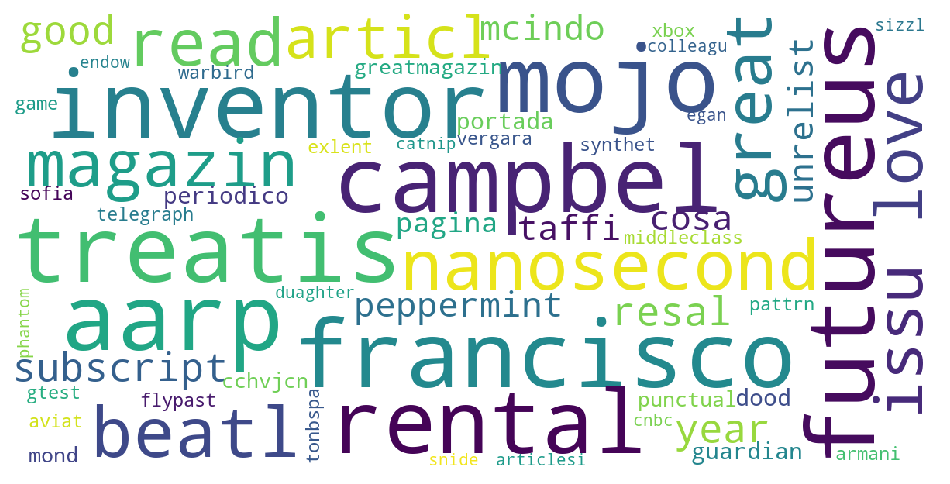

In [514]:
show_wordcloud(word)



## SAVING MODEL

In [79]:
print(lda.isDistributed())
path="C:\\Users\\Arvind\\Downloads\\model\\"

model_number="2"
model.save(path+'CVModel'+model_number)
lda.save(path+'LDAModel'+model_number)


False


## TRANSFORMATION

Here we transformed our LDA model. After transforming the model we can see that all the terms of top topics with topicDistribution are given.

In [82]:
dk=modelda.transform(result)
dk.show(truncate=False)

+---+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [77]:
df1=dk.select("topicDistribution", "IDX", "words").sort("topicDistribution", ascending=False, N=5)

In [78]:
df1.show(truncate=False)
        

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## TOPICSMATRIX

Inferred topics, where each topic is represented by a distribution over terms.

In [561]:
topicMat=modelda.topicsMatrix()

In [563]:
print(topicMat)

DenseMatrix([[5.44890465e+04, 5.02018440e-02, 5.00346601e-02, ...,
              5.02391282e-02, 5.03181998e-02, 1.52081012e-01],
             [1.81764832e+04, 5.00582322e-02, 5.00172861e-02, ...,
              5.00410403e-02, 5.00996547e-02, 9.37385923e-02],
             [1.64382893e+04, 5.02355229e-02, 5.00255690e-02, ...,
              5.01412583e-02, 5.00267476e-02, 5.06892827e-02],
             ...,
             [1.12675968e+00, 5.00014453e-02, 5.00013744e-02, ...,
              5.00017202e-02, 5.00015145e-02, 5.00016424e-02],
             [8.60631767e-01, 5.00014978e-02, 5.00018373e-02, ...,
              5.00014241e-02, 5.00015778e-02, 5.00013467e-02],
             [5.00016332e-02, 5.00015778e-02, 5.00015397e-02, ...,
              5.00014006e-02, 5.00014177e-02, 5.00018066e-02]])


In [177]:
modelda.topicsMatrix()

DenseMatrix(44681, 20, [54489.0465, 18176.4832, 16438.2893, 15944.1893, 15062.0797, 14817.7308, 13015.3231, 12542.2684, ..., 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], 0)

## HASHINGTF

Here hashingTF applied although didn't used in the model. As after literature survey we found that the best technique for vectorization is countVectorizer for LDA modeling.

In [536]:
import os                  #bag of words
from pyspark import SparkContext
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF    

train = os.listdir("C:\\Users\\salon\\Downloads") #create a list of file names
hashingTF = HashingTF()

for i in range(0,len(train)):
    #create RDD of each text file, split into words and (attempt) to make hash table
    doc = sc.textFile("C:\\Users\\salon\\Downloads\\Magazine_Subscriptions.json").map(lambda line: line.split(" "))
    print(doc)

tf = hashingTF.transform('doc')

print(tf)

(1048576,[11634,58590,502024],[1.0,1.0,1.0])
